# Análisis Exploratorio y Limpieza de Datos – Proyecto Telco Customer Churn

## Descarga del dataset / imports necesarios para analisis y limpieza

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel("Telco_customer_churn.xlsx")

## Analisis de información básica

In [3]:
data.shape

(7043, 33)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [5]:
data.head(3)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved


In [6]:
data.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [7]:
data.describe().round(2)

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,1.0,93521.96,36.28,-119.80,32.37,64.76,0.27,58.70,4400.30
std,0.0,1865.79,2.46,2.16,24.56,30.09,0.44,21.53,1183.06
min,1.0,90001.00,32.56,-124.30,0.00,18.25,0.00,5.00,2003.00
25%,1.0,92102.00,34.03,-121.82,9.00,35.50,0.00,40.00,3469.00
50%,1.0,93552.00,36.39,-119.73,29.00,70.35,0.00,61.00,4527.00
75%,1.0,95351.00,38.22,-118.04,55.00,89.85,1.00,75.00,5380.50
max,1.0,96161.00,41.96,-114.19,72.00,118.75,1.00,100.00,6500.00


## Exploración para detectar posibles columnas que no aporten nada al modelo

#### Hacemos una exploración general usando el código siguiente: 

In [8]:
col = "Phone Service"

print(f"--- Análisis de la columna: {col} ---\n")

# Tipo de dato
print("Tipo de dato (dtype):")
print(data[col].dtype)
print("\n")

# Valores únicos
print("Valores únicos:")
print(sorted(data[col].unique()))
print("\n")

# Número de categorías / valores distintos
print("Número de categorías:")
print(data[col].nunique())
print("\n")

# Frecuencias
print("Frecuencias:")
print(data[col].value_counts(dropna=False))  



--- Análisis de la columna: Phone Service ---

Tipo de dato (dtype):
object


Valores únicos:
['No', 'Yes']


Número de categorías:
2


Frecuencias:
Phone Service
Yes    6361
No      682
Name: count, dtype: int64


#### La columna **Total Charges** da problemas. Investigamos y observamos que tiene una lista de valores numericos dentro de un objeto. También tiene strings vacios. Requiere transformación asi que parseamos y sustituimos nulos por la multiplicación entre Monthly Charges y Tenure Months:

In [9]:
import numpy as np

def parse_total_charges(x):
    # Si ya es numérico, lo pasamos a float directamente
    if isinstance(x, (int, float, np.number)):
        return float(x)
    
    # Si es lista/tupla/array, cogemos el primer elemento (si lo hay)
    if isinstance(x, (list, tuple, np.ndarray)):
        if len(x) == 0:
            return np.nan
        x = x[0]
    
    # A partir de aquí tratamos x como texto
    s = str(x).strip()
    if s == "":
        return np.nan
    
    # Por si acaso hubiera comas decimales
    s = s.replace(",", ".")
    
    # Intentamos convertir a float
    try:
        return float(s)
    except ValueError:
        return np.nan

# Aplicamos la función a toda la columna
data["Total Charges"] = data["Total Charges"].apply(parse_total_charges)

print("dtype después de parsear:", data["Total Charges"].dtype)
print("Nulos después de parsear:", data["Total Charges"].isna().sum())
print(data["Total Charges"].head(10))



dtype después de parsear: float64
Nulos después de parsear: 11
0     108.15
1     151.65
2     820.50
3    3046.05
4    5036.30
5     528.35
6      39.65
7      20.15
8    4749.15
9      30.20
Name: Total Charges, dtype: float64


In [10]:
data[["Total Charges", "Monthly Charges", "Tenure Months"]]

,Total Charges,Monthly Charges,Tenure Months
0,108.15,53.85,2
1,151.65,70.70,2
2,820.50,99.65,8
3,3046.05,104.80,28
4,5036.30,103.70,49
...,...,...,...
7038,1419.40,21.15,72
7039,1990.50,84.80,24
7040,7362.90,103.20,72
7041,346.45,29.60,11


In [11]:
mask_fill = (
    data["Total Charges"].isna() &
    (data["Tenure Months"] == 0)
)

print("Filas a imputar:", mask_fill.sum())
data.loc[mask_fill, ["Tenure Months", "Monthly Charges", "Total Charges"]].head(10)


Filas a imputar: 11


,Tenure Months,Monthly Charges,Total Charges
2234,0,52.55,NaN
2438,0,20.25,NaN
2568,0,80.85,NaN
2667,0,25.75,NaN
2856,0,56.05,NaN
4331,0,19.85,NaN
4687,0,25.35,NaN
5104,0,20.00,NaN
5719,0,19.70,NaN
6772,0,73.35,NaN


In [12]:
data.loc[mask_fill, "Total Charges"] = data.loc[mask_fill, "Monthly Charges"]


In [13]:
# Ya no debería haber NaN en esas filas
print("Nulos restantes en Total Charges:", data["Total Charges"].isna().sum())

data.loc[mask_fill, ["Tenure Months", "Monthly Charges", "Total Charges"]].head(10)


Nulos restantes en Total Charges: 0


,Tenure Months,Monthly Charges,Total Charges
2234,0,52.55,52.55
2438,0,20.25,20.25
2568,0,80.85,80.85
2667,0,25.75,25.75
2856,0,56.05,56.05
4331,0,19.85,19.85
4687,0,25.35,25.35
5104,0,20.00,20.00
5719,0,19.70,19.70
6772,0,73.35,73.35


### 1. **Total Charges** viene totalmente explicada por Tenure Months y Monthly Charges: ELIMINAR

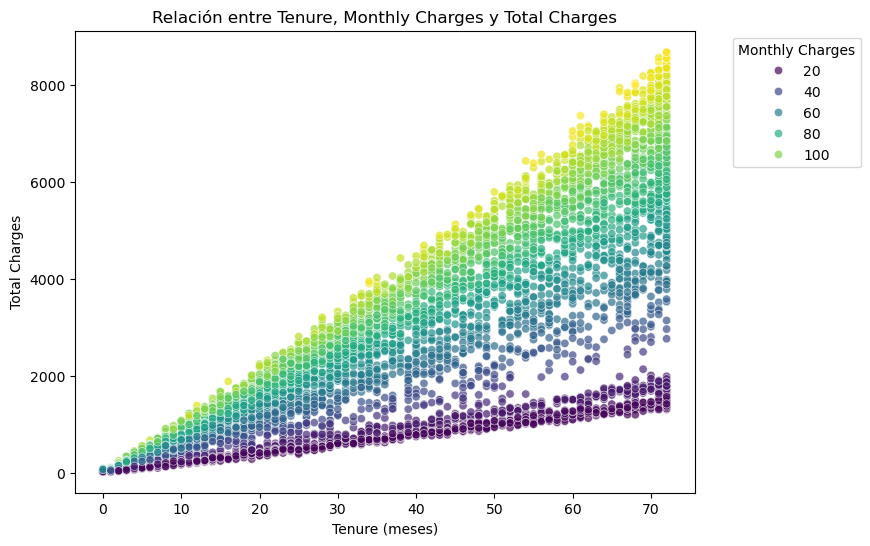

In [14]:
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    data=data,
    x="Tenure Months",      
    y="Total Charges",
    hue="Monthly Charges",
    palette="viridis",
    alpha=0.7
)

plt.title("Relación entre Tenure, Monthly Charges y Total Charges")
plt.xlabel("Tenure (meses)")
plt.ylabel("Total Charges")
plt.legend(title="Monthly Charges", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout
plt.savefig("churn_plot.svg", bbox_inches="tight")
plt.show()


### 2. Churn Label es la representación en texto de Churn Value: ELIMINAR

<Axes: xlabel='Churn Value', ylabel='Churn Label'>

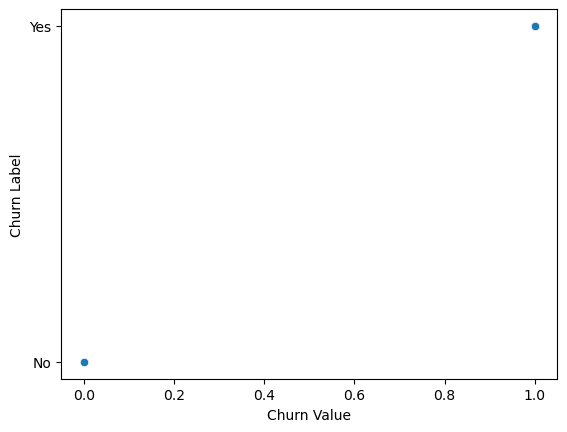

In [15]:
sns.scatterplot(                    
     data = data,
     x = "Churn Value",
     y = "Churn Label"
 )

In [16]:
(data["Churn Label"].map({"Yes": 1, "No": 0}) == data["Churn Value"]).all() 

True

### 3. **CustomerID** son todo valores unicos para todas las filas: ELIMINAR

In [17]:
data.shape[0] == data.CustomerID.nunique() #son todo valores distintos y aleatorios

True

In [18]:
data.CustomerID.duplicated().sum() #no hay duplicados

0

### 4. **Count, Country y State** son todo valores unicos para todas las filas: ELIMINAR

In [19]:
data.Count.unique(), data.Country.unique(), data.State.unique() # columnas con un valor único para todos los registros

(array([1], dtype=int64),
 array(['United States'], dtype=object),
 array(['California'], dtype=object))

### 5. **Lat Long** es una columna objeto totalmente explicada por Latitude y Longitud: ELIMINAR

In [20]:
data[["Lat Long", "Latitude", "Longitude"]].head(5) # vemos que es redundante

,Lat Long,Latitude,Longitude
0,"33.964131, -118.272783",33.964131,-118.272783
1,"34.059281, -118.30742",34.059281,-118.307420
2,"34.048013, -118.293953",34.048013,-118.293953
3,"34.062125, -118.315709",34.062125,-118.315709
4,"34.039224, -118.266293",34.039224,-118.266293


### 6. **Churn Score** es la predicción anterior que queremos mejorar: ELIMINAR (pero guardo copia para comparación posterior)

In [21]:
churn_score = data["Churn Score"].copy() # guardo una copia para comparar en el futuro

### 7. **Churn Reason** son los motivos de abandono del servicio. no puedo incluir en un modelo para predecir un dato que es posterior a dicha predicción: ELIMINAR (guardo copia y relleno nulos por "Not Churned", ya que coinciden con clientes que no abandonaron el servicio)

In [22]:
churn_reason = data["Churn Reason"].copy() # guardo una copia para comparar en el futuro

In [23]:
churn_reason = churn_reason.fillna("Not Churned") # sustituyo nulos por valores de personas que no hicieron churn

In [24]:
churn_reason

0        Competitor made better offer
1                               Moved
2                               Moved
3                               Moved
4       Competitor had better devices
                    ...              
7038                      Not Churned
7039                      Not Churned
7040                      Not Churned
7041                      Not Churned
7042                      Not Churned
Name: Churn Reason, Length: 7043, dtype: object

### 8. *City* tiene 1129 valores únicos en un df de 7043. Podemos agrupar por counties, pero aún así son 58, muy complicado de llevar a dummies: ELIMINAR

In [25]:
data.City.nunique()

1129

In [26]:
data["City"].value_counts(dropna=False)

City
Los Angeles       305
San Diego         150
San Jose          112
Sacramento        108
San Francisco     104
                 ... 
Healdsburg          4
Jenner              4
Philo               4
Point Arena         4
Olympic Valley      4
Name: count, Length: 1129, dtype: int64

C:\Users\osian\AppData\Local\Temp\ipykernel_11352\3068191003.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = data, x = "Gender", y = "Churn Value", palette="tab10")


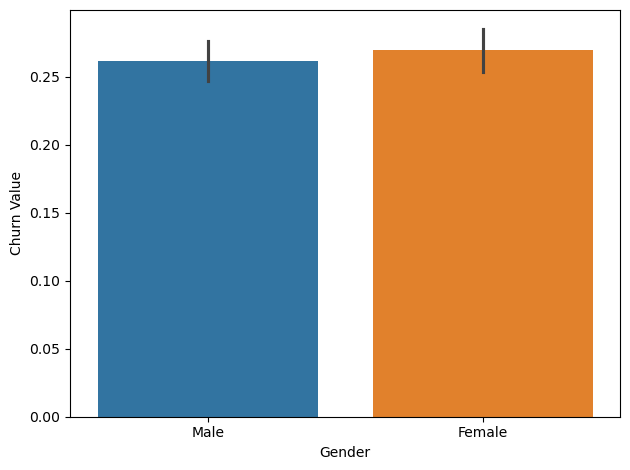

In [27]:
sns.barplot(data = data, x = "Gender", y = "Churn Value", palette="tab10")
plt.tight_layout()
plt.savefig("gender_plot.svg", bbox_inches="tight")
plt.show()

##### El genero no explica nada: ELIMINAR

## Columnas elegidas para ser eliminadas:  

In [28]:
data.drop(columns=["City","CustomerID", "Count", "Country", "State", "Lat Long", "Churn Score", "Churn Label", "Churn Reason", "Total Charges", "Gender"], inplace=True)

In [29]:
data.columns

Index(['Zip Code', 'Latitude', 'Longitude', 'Senior Citizen', 'Partner',
       'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Churn Value', 'CLTV'],
      dtype='object')

### Tratamos duplicados: No hay asi que no hacemos nada

In [30]:
data.duplicated().sum()
# data = data.drop_duplicates()

0

## Limpieza básica inicial de espacios sobrantes y transformación a minúsculas de columnas categóricas

In [31]:
cols_cat = data.select_dtypes(include="object").columns

def clean_general(s):
    s = s.astype("string")
    s = s.str.strip()
    s = s.str.replace(r"\s+", " ", regex=True)
    s = s.str.lower()          # seguro en datos USA
    return s

data[cols_cat] = data[cols_cat].apply(clean_general)

In [32]:
data.head(3)

,Zip Code,Latitude,Longitude,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Value,CLTV
0,90003,33.964131,-118.272783,no,no,no,2,yes,no,dsl,...,no,no,no,no,month-to-month,yes,mailed check,53.85,1,3239
1,90005,34.059281,-118.307420,no,no,yes,2,yes,no,fiber optic,...,no,no,no,no,month-to-month,yes,electronic check,70.70,1,2701
2,90006,34.048013,-118.293953,no,no,yes,8,yes,yes,fiber optic,...,yes,no,yes,yes,month-to-month,yes,electronic check,99.65,1,5372


## Tratamiento de Nulos: Noy hay asi que no hacemos nada

In [33]:
data.isnull().sum()

Zip Code             0
Latitude             0
Longitude            0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Churn Value          0
CLTV                 0
dtype: int64

## Gráficos de análisis

### Countplot de variable objetivo: Tenemos datos evidentemente desbalanceados, asi que usaremos **smote** más adelante

C:\Users\osian\AppData\Local\Temp\ipykernel_11352\3534366596.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="Churn Value", palette="tab10")


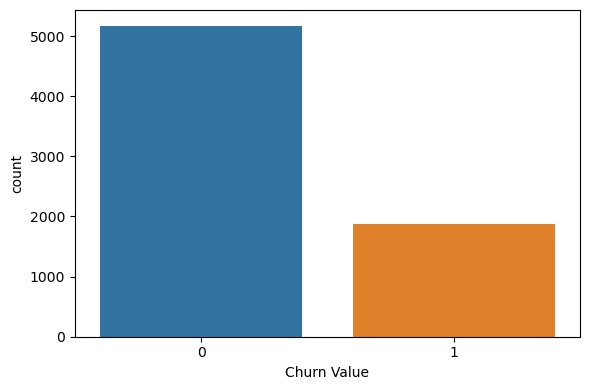

In [34]:
plt.figure(figsize=(6,4))
plt.xticks(rotation=0)
sns.countplot(data=data, x="Churn Value", palette="tab10")
plt.tight_layout()
plt.savefig("churnValue_plot.svg", bbox_inches="tight")
plt.show()

In [35]:
churn_percentage = (data["Churn Value"].sum() / data.shape[0] * 100).round(2)
churn_percentage

26.54

### Histogramas de variables numéricas: Apreciamos: 
##### 1. Zip code tiene valores muy repartidos y puede ser irrelevante
##### 2. Tenure Months y Monthly Charges tienen información interesante a explorar en detalle
##### 3. CLTV tiene 3 grupos marcados: gastaron hasta 4.000, gastaron hasta 6.000, y gastaron hasta 6.500

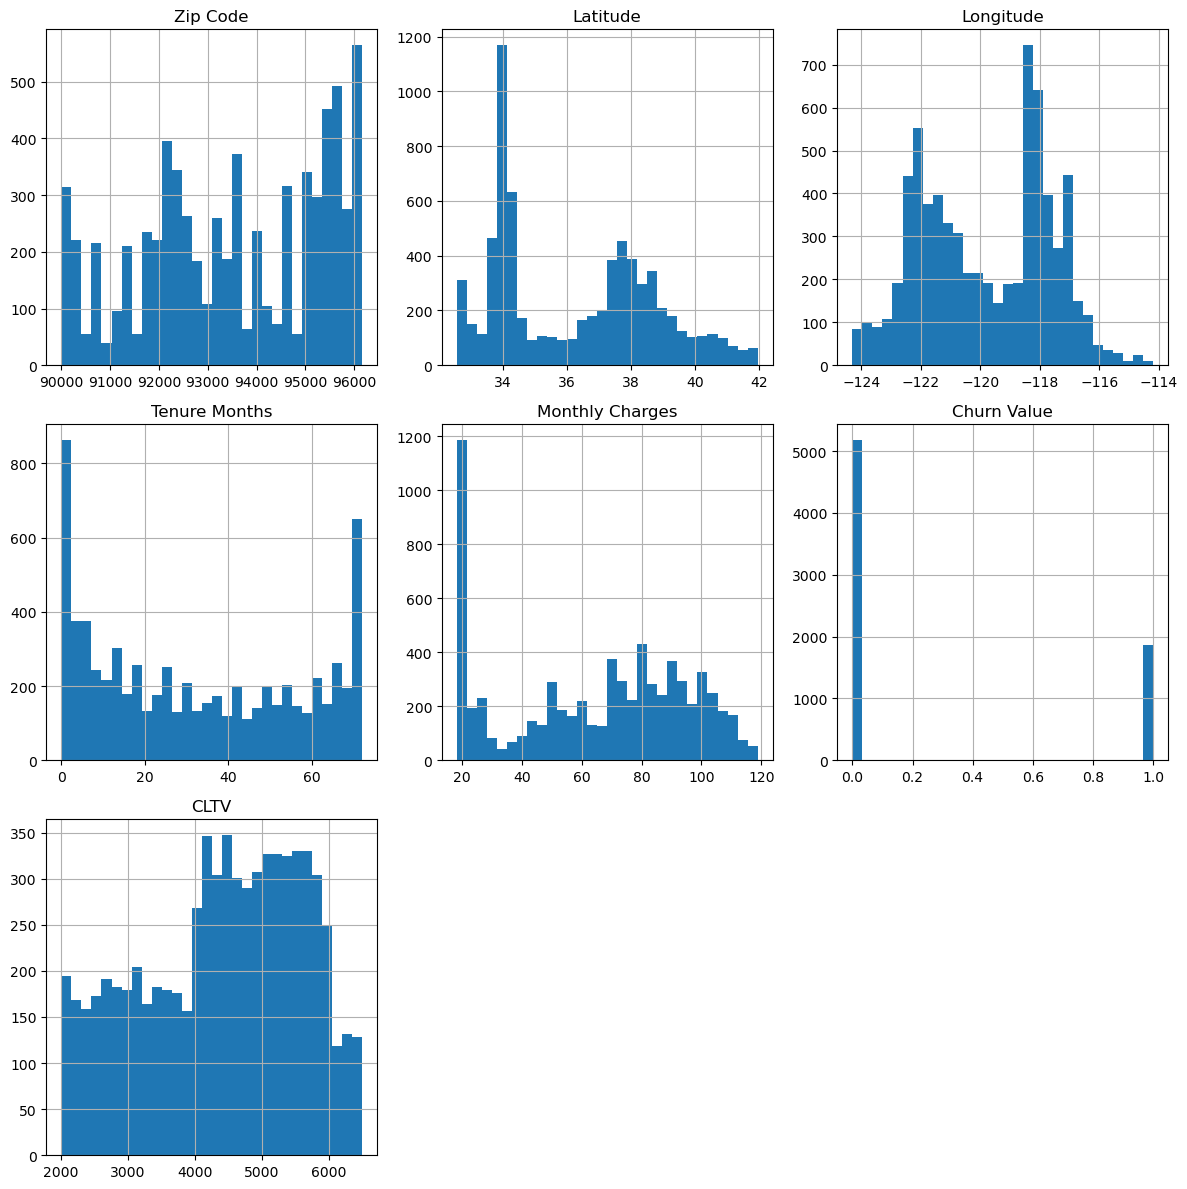

In [36]:
data.hist(figsize=(12,12), bins=30)
plt.tight_layout()
plt.show()

## Buscamos patrones concretos entre variables:  

### 1. CLTV - Contract. obs: No parece haber ninguna tendencia relevante, pero si ayudan a explicar la variable, porque hay diferencias significativas

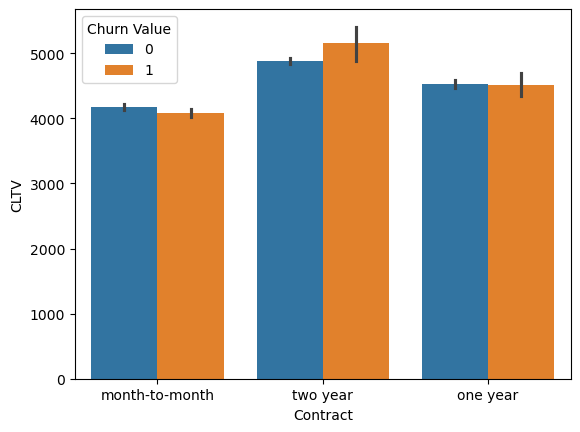

In [37]:
sns.barplot(data = data, x = "Contract", y = "CLTV", hue="Churn Value")
plt.show()

### 1. Monthly Charges - Tenure Months. obs: Aqui observamos una relación MUY directa con el churn. El comportamiento del churn respecto a estas varibles nos revela que: 
##### a) Los usuarios abandonan mucho el servicio en los primeros meses
##### b) Los usuarios que más abandonan el servicio son los que más cuota mensual pagan

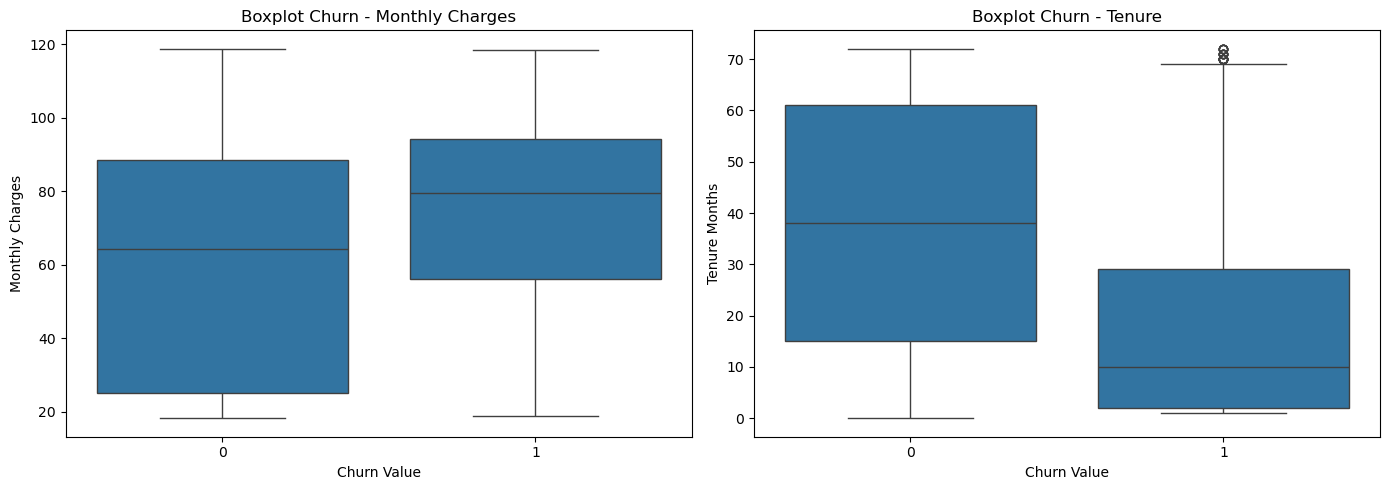

In [38]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.boxplot(data=data, x="Churn Value", y="Monthly Charges", ax=axes[0])
axes[0].set_title("Boxplot Churn - Monthly Charges")

sns.boxplot(data=data, x="Churn Value", y="Tenure Months", ax=axes[1])
axes[1].set_title("Boxplot Churn - Tenure")

plt.tight_layout()
plt.show()


C:\Users\osian\AppData\Local\Temp\ipykernel_11352\1758537576.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Monthly_bin")["Churn Value"]
C:\Users\osian\AppData\Local\Temp\ipykernel_11352\1758537576.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Tenure_bin")["Churn Value"]


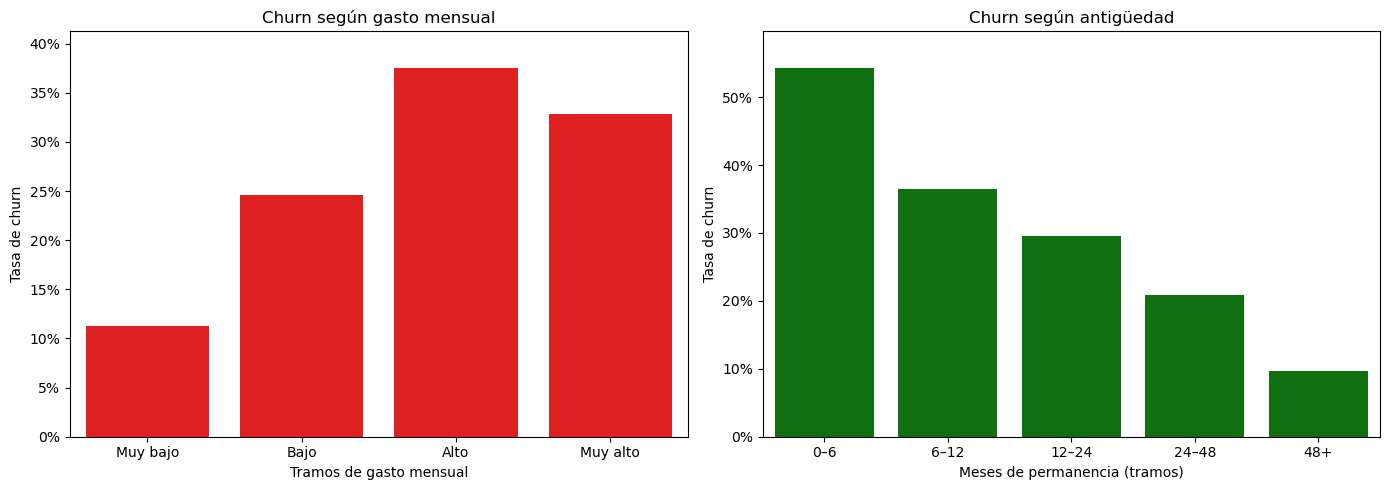

In [39]:
# Copia para no ensuciar el original
df = data.copy()

# --- 1) Tramos de gasto mensual + churn rate ---
df["Monthly_bin"] = pd.qcut(
    df["Monthly Charges"], q=4,
    labels=["Muy bajo", "Bajo", "Alto", "Muy alto"]
)

monthly_churn = (
    df.groupby("Monthly_bin")["Churn Value"]
      .mean()
      .reset_index(name="churn_rate")
)

# --- 2) Tramos de tenure + churn rate ---
bins = [0, 6, 12, 24, 48, np.inf]
labels = ["0–6", "6–12", "12–24", "24–48", "48+"]

df["Tenure_bin"] = pd.cut(
    df["Tenure Months"], bins=bins,
    labels=labels, right=False
)

tenure_churn = (
    df.groupby("Tenure_bin")["Churn Value"]
      .mean()
      .reset_index(name="churn_rate")
)

# --- Plots lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=monthly_churn, x="Monthly_bin", y="churn_rate", color="red", ax=axes[0])
axes[0].set_ylabel("Tasa de churn")
axes[0].set_xlabel("Tramos de gasto mensual")
axes[0].set_title("Churn según gasto mensual")
axes[0].set_ylim(0, monthly_churn["churn_rate"].max() * 1.1)
axes[0].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

sns.barplot(data=tenure_churn, x="Tenure_bin", y="churn_rate", color="green",ax=axes[1])
axes[1].set_ylabel("Tasa de churn")
axes[1].set_xlabel("Meses de permanencia (tramos)")
axes[1].set_title("Churn según antigüedad")
axes[1].set_ylim(0, tenure_churn["churn_rate"].max() * 1.1)
axes[1].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

plt.tight_layout()
plt.savefig("Tenure_Charges_plots.svg", bbox_inches="tight")
plt.show()


##### Los clientes que abandonan pagan típicamente más al mes.
##### Es una señal clara de que Monthly Charges está asociado al churn.
##### Monthly Charges es una variable potencialmente importante para predecir churn.

C:\Users\osian\AppData\Local\Temp\ipykernel_11352\1014362279.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Tenure_bin", "Monthly_bin"])["Churn Value"]


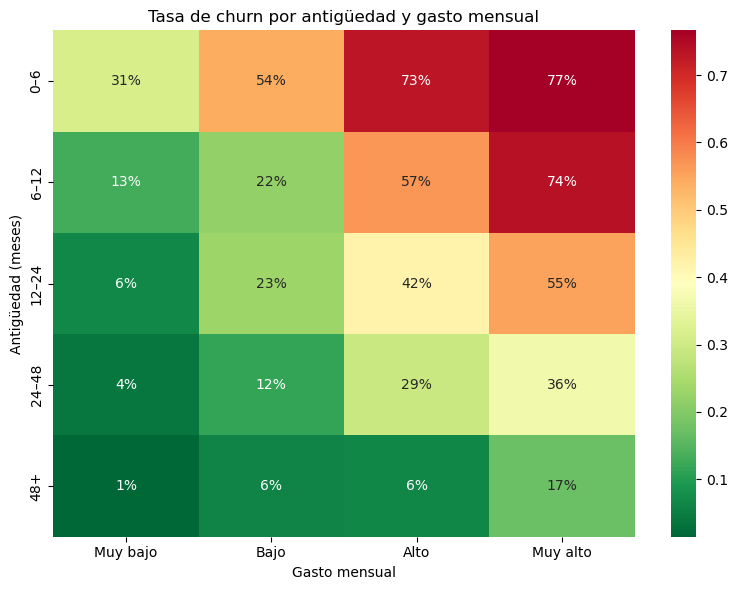

In [40]:
# Reutilizamos los bins anteriores o los ajustas a tu gusto
df["Monthly_bin"] = pd.qcut(df["Monthly Charges"], q=4,
                            labels=["Muy bajo", "Bajo", "Alto", "Muy alto"])

bins_tenure = [0, 6, 12, 24, 48, np.inf]
labels_tenure = ["0–6", "6–12", "12–24", "24–48", "48+"]

df["Tenure_bin"] = pd.cut(df["Tenure Months"], bins=bins_tenure,
                          labels=labels_tenure, right=False)

# Tabla de churn medio por combinación de tramos
heat = (
    df.groupby(["Tenure_bin", "Monthly_bin"])["Churn Value"]
      .mean()
      .unstack()   # filas = Tenure, columnas = Monthly
)

plt.figure(figsize=(8,6))
sns.heatmap(heat, annot=True, fmt=".0%", cmap="RdYlGn_r")
plt.title("Tasa de churn por antigüedad y gasto mensual")
plt.xlabel("Gasto mensual")
plt.ylabel("Antigüedad (meses)")

plt.tight_layout()
plt.savefig("Tenure_Charges_heatmap.svg", bbox_inches="tight")
plt.show()


## **Conclusion importante**: Los clientes que adoptan el servicio a bajo coste se fidelizan, pero aquellos que entran con muchos extras suelen abandonar. Esto es un dato muy importante para el área de negocio. 

## Analisis de multicolinealidad Exploratorio (solo columnas numéricas)

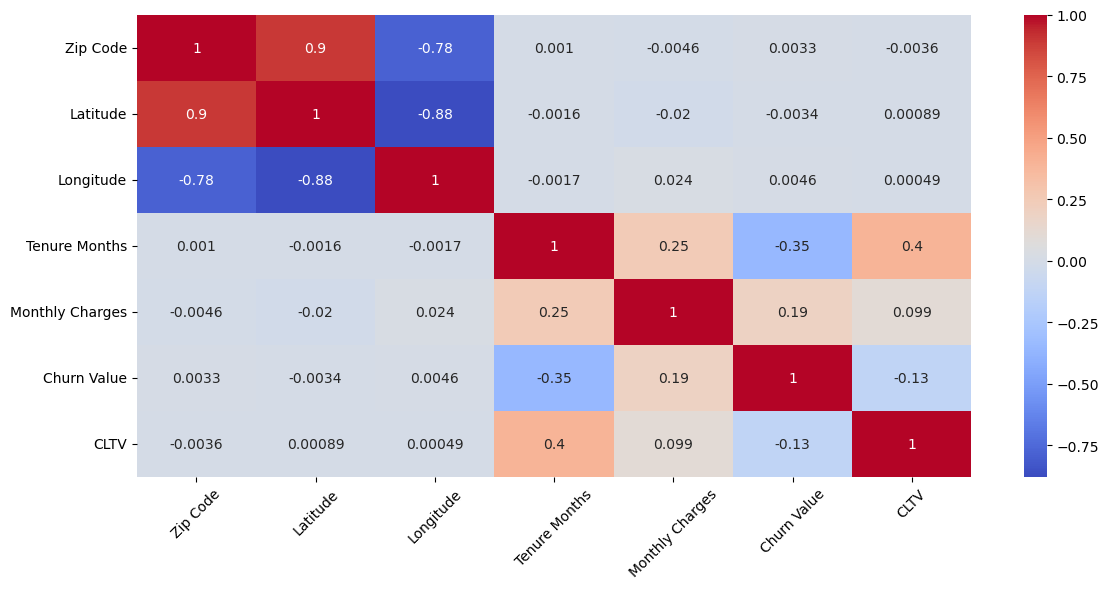

In [41]:
num_cols = data.select_dtypes(include=["int64", "float64"]).columns
corr = data[num_cols].corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("geo_corr_heatmap.svg", bbox_inches="tight")
plt.show()


### Eliminamos **Zip Code**(correlación altisima) y volvemos a ver el mapa de calor: 

In [42]:
data.drop(columns=["Zip Code"], inplace=True)

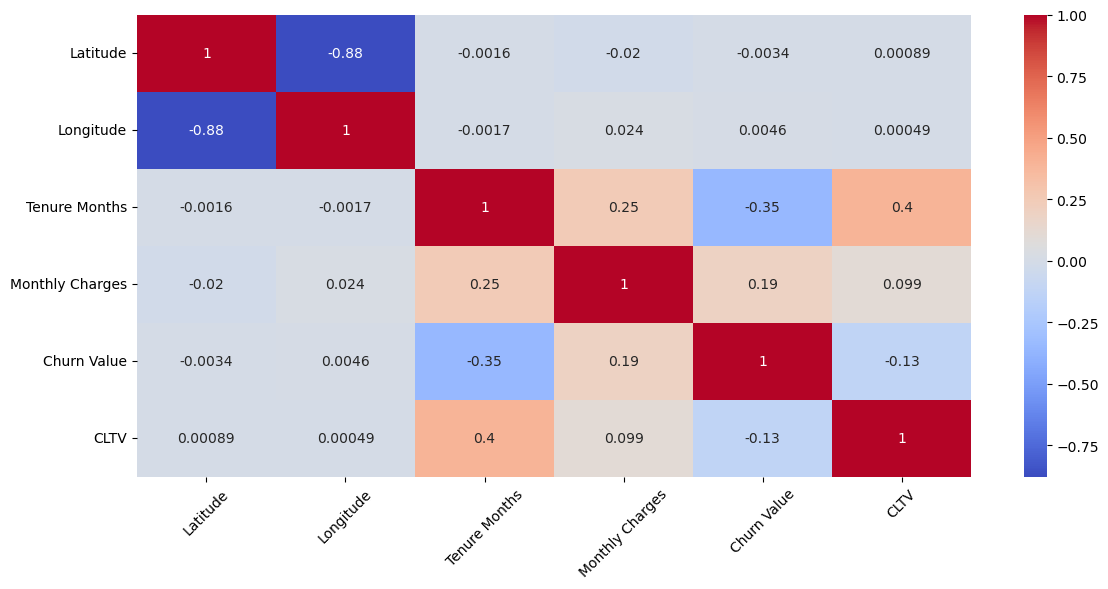

In [43]:
num_cols = data.select_dtypes(include=["int64", "float64"]).columns
corr = data[num_cols].corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("geo_corr2_heatmap.svg", bbox_inches="tight")
plt.show()

### Probamos a crear una Variable compuesta por Latitude y Longitud, a través de la obtención de 5 zonas geograficas

### Creamos la GeoZone

In [46]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = data.copy()

# 1) Asegurar numéricos y gestionar nulos
coords = df[["Latitude", "Longitude"]].apply(pd.to_numeric, errors="coerce")
mask_ok = coords.notna().all(axis=1)

# 2) Escalado (importante para KMeans)
scaler = StandardScaler()
X = scaler.fit_transform(coords.loc[mask_ok, ["Latitude", "Longitude"]])

# 3) Centroides iniciales (aprox) para 5 "zonas reales" de CA
#    (puedes ajustar si tu distribución está muy sesgada)
seed_centers = np.array([
    [37.7749, -122.4194],  # Bay Area (San Francisco)
    [34.0522, -118.2437],  # Greater Los Angeles (Los Angeles)
    [32.7157, -117.1611],  # San Diego (San Diego)
    [38.5816, -121.4944],  # Sacramento / NorCal interior (Sacramento)
    [36.7378, -119.7871],  # Central Valley (Fresno)
], dtype=float)

init_centers = scaler.transform(seed_centers)

# 4) KMeans arrancando desde esos centros
kmeans = KMeans(
    n_clusters=5,
    init=init_centers,
    n_init=1,           # mantenemos esos centros como arranque (no reintentos aleatorios)
    random_state=42
)

labels = kmeans.fit_predict(X)

# 5) Guardar cluster 1..5 + etiqueta "humana"
df["GeoCluster"] = np.nan
df.loc[mask_ok, "GeoCluster"] = (labels + 1).astype(int)

zone_names = {
    1: "Bay Area",
    2: "Greater Los Angeles",
    3: "San Diego",
    4: "Sacramento / NorCal interior",
    5: "Central Valley",
}
df["GeoZone"] = df["GeoCluster"].map(zone_names)

# (opcional) ver tamaños
print(df["GeoZone"].value_counts(dropna=False))


C:\tools\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\tools\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\tools\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\tools\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\tools\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(a

GeoZone
Bay Area                        2312
Greater Los Angeles             2101
San Diego                       1026
Central Valley                   804
Sacramento / NorCal interior     800
Name: count, dtype: int64


### Graficamos la GeoZone

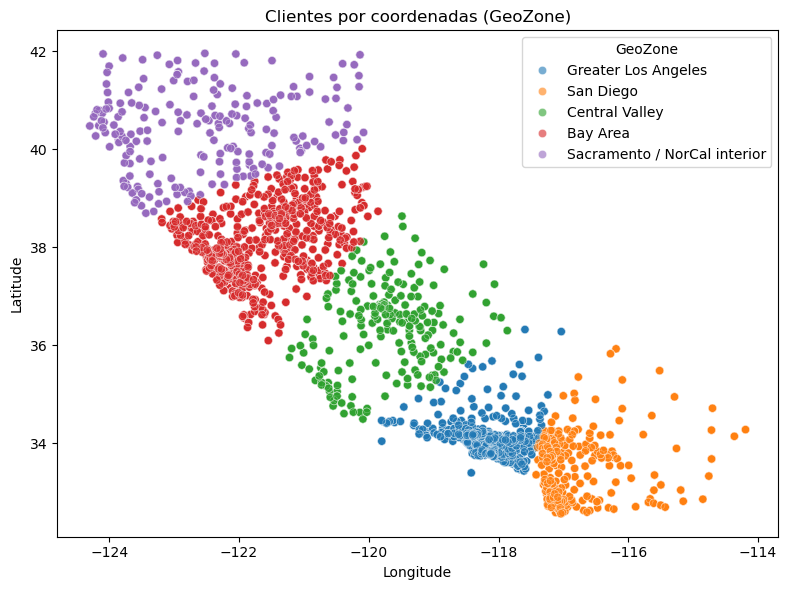

In [49]:
plot_df = df.loc[mask_ok, ["Longitude","Latitude","GeoZone"]].copy()

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df, x="Longitude", y="Latitude", hue="GeoZone", alpha=0.6)
plt.title("Clientes por coordenadas (GeoZone)")

plt.tight_layout()
plt.savefig("geo_map_scatter.svg", bbox_inches="tight")
plt.show()


### Calculamos churn rate por zona

In [45]:
zone_summary = (
    df.groupby("GeoZone", dropna=False)
      .agg(
          n_clientes=("Churn Value", "size"),
          churn_total=("Churn Value", "sum"),
          churn_rate=("Churn Value", "mean")
      )
      .sort_values("n_clientes", ascending=False)
)

# (opcional) en porcentaje
zone_summary["churn_rate_pct"] = (zone_summary["churn_rate"] * 100).round(2)

zone_summary


,n_clientes,churn_total,churn_rate,churn_rate_pct
GeoZone,,,,
Bay Area,2312,628,0.271626,27.16
Greater Los Angeles,2101,551,0.262256,26.23
San Diego,1026,293,0.285575,28.56
Central Valley,804,194,0.241294,24.13
Sacramento / NorCal interior,800,203,0.253750,25.37


#### CON ESTOS DATOS VEMOS QUE NO HAY RELACIÓN ALGUNA ENTRE EL CHURN Y LAS ZONAS GEOGRÁFICAS: ELIMINAMOS LATITUD Y LONGITUD DEL MODELO

In [46]:
data.drop(columns=["Longitude","Latitude"], inplace=True)

In [47]:
data.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Churn Value', 'CLTV'],
      dtype='object')

## Creación de columnas Binarias y Dummies: 

### Primero colapsamos categorias redundantes. La tercera opcion de muchas variables viene explicada por otra columna
### En nuetro caso "no phone service" o "no internet service" ya vienen explicadas en **Phone Service** e **Internet Service** 

In [48]:
cols_no_internet = [
    "Online Security",
    "Online Backup",
    "Device Protection",
    "Tech Support",
    "Streaming TV",
    "Streaming Movies"
]

for col in cols_no_internet:
    data[col] = data[col].replace({"no internet service": "no"})


In [49]:
data["Multiple Lines"] = data["Multiple Lines"].replace({"no phone service": "no"})


In [50]:
cols_no_internet = [
    "Online Security",
    "Online Backup",
    "Device Protection",
    "Tech Support",
    "Streaming TV",
    "Streaming Movies",
    "Multiple Lines"
]

for i in cols_no_internet:
    print(data[i].unique())

<StringArray>
['yes', 'no']
Length: 2, dtype: string
<StringArray>
['yes', 'no']
Length: 2, dtype: string
<StringArray>
['no', 'yes']
Length: 2, dtype: string
<StringArray>
['no', 'yes']
Length: 2, dtype: string
<StringArray>
['no', 'yes']
Length: 2, dtype: string
<StringArray>
['no', 'yes']
Length: 2, dtype: string
<StringArray>
['no', 'yes']
Length: 2, dtype: string


In [51]:
data["Internet Service"].unique()

<StringArray>
['dsl', 'fiber optic', 'no']
Length: 3, dtype: string

In [52]:
data["Contract"].unique()

<StringArray>
['month-to-month', 'two year', 'one year']
Length: 3, dtype: string

In [53]:
data["Payment Method"].unique()

<StringArray>
[             'mailed check',          'electronic check',
 'bank transfer (automatic)',   'credit card (automatic)']
Length: 4, dtype: string

## binarias: 

In [54]:
# Columnas binarias Yes/No
cols_binarias = [
    "Senior Citizen",
    "Partner",
    "Dependents",
    "Phone Service",
    "Paperless Billing",
     "Online Security",
    "Online Backup",
    "Device Protection",
    "Tech Support",
    "Streaming TV",
    "Streaming Movies",
    "Multiple Lines"
]

# Mapear Yes → 1, No → 0
for col in cols_binarias:
    data[col] = data[col].map({"yes": 1, "no": 0})

# Gender (Male/Female)
data["Gender"] = data["Gender"].map({"male": 1, "female": 0})


In [55]:
cols_binarias = [
    "Senior Citizen",
    "Partner",
    "Dependents",
    "Phone Service",
    "Paperless Billing",
    "Online Security",
    "Online Backup",
    "Device Protection",
    "Tech Support",
    "Streaming TV",
    "Streaming Movies",
    "Multiple Lines",
    "Gender"
]

for i in cols_binarias: 
    print(data[i].unique())

[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]


In [56]:
data["Gender"].unique()

array([1, 0], dtype=int64)

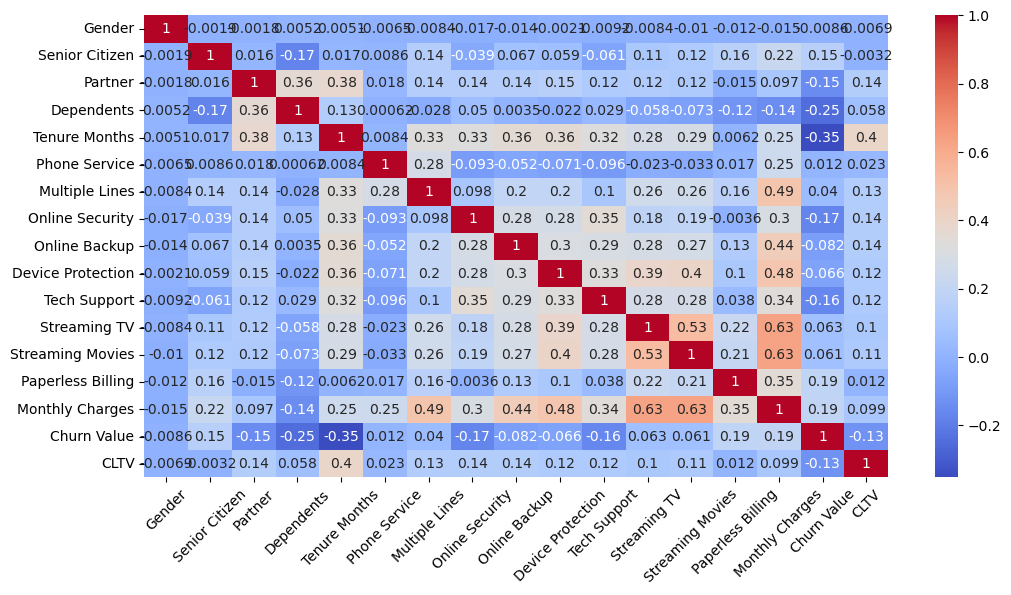

In [57]:
num_cols = data.select_dtypes(include=["int64", "float64"]).columns
corr = data[num_cols].corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.xticks(rotation=45)
plt.show()

#### Dummies:

In [58]:
cat_cols = data.select_dtypes(include=["string"]).columns.tolist()
print(cat_cols)

['Internet Service', 'Contract', 'Payment Method']


In [59]:
data_dummies = pd.get_dummies(data, columns=cat_cols, drop_first=True)

In [60]:
data_dummies.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,...,Monthly Charges,Churn Value,CLTV,Internet Service_fiber optic,Internet Service_no,Contract_one year,Contract_two year,Payment Method_credit card (automatic),Payment Method_electronic check,Payment Method_mailed check
0,1,0,0,0,2,1,0,1,1,0,...,53.85,1,3239,False,False,False,False,False,False,True
1,0,0,0,1,2,1,0,0,0,0,...,70.70,1,2701,True,False,False,False,False,True,False
2,0,0,0,1,8,1,1,0,0,1,...,99.65,1,5372,True,False,False,False,False,True,False
3,0,0,1,1,28,1,1,0,0,1,...,104.80,1,5003,True,False,False,False,False,True,False
4,1,0,0,1,49,1,1,0,1,1,...,103.70,1,5340,True,False,False,False,False,False,False


In [61]:
data_dummies.shape

(7043, 24)

#### transformamos todas las dummies a binarias

In [62]:
bool_cols = data_dummies.select_dtypes(include="bool").columns
data_dummies[bool_cols] = data_dummies[bool_cols].astype(int)

In [63]:
data_dummies.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,...,Monthly Charges,Churn Value,CLTV,Internet Service_fiber optic,Internet Service_no,Contract_one year,Contract_two year,Payment Method_credit card (automatic),Payment Method_electronic check,Payment Method_mailed check
0,1,0,0,0,2,1,0,1,1,0,...,53.85,1,3239,0,0,0,0,0,0,1
1,0,0,0,1,2,1,0,0,0,0,...,70.70,1,2701,1,0,0,0,0,1,0
2,0,0,0,1,8,1,1,0,0,1,...,99.65,1,5372,1,0,0,0,0,1,0
3,0,0,1,1,28,1,1,0,0,1,...,104.80,1,5003,1,0,0,0,0,1,0
4,1,0,0,1,49,1,1,0,1,1,...,103.70,1,5340,1,0,0,0,0,0,0


## Separamos X e y

In [64]:
y = data_dummies["Churn Value"]
X = data_dummies.drop("Churn Value", axis=1)

In [65]:
X.shape, y.shape

((7043, 23), (7043,))

In [66]:
import pickle

payload = {
    "X": X,
    "y": y,
    "feature_names": X.columns.tolist()
}

with open("data_clean.pkl", "wb") as f:
    pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)


In [67]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Gender                                  7043 non-null   int64  
 1   Senior Citizen                          7043 non-null   int64  
 2   Partner                                 7043 non-null   int64  
 3   Dependents                              7043 non-null   int64  
 4   Tenure Months                           7043 non-null   int64  
 5   Phone Service                           7043 non-null   int64  
 6   Multiple Lines                          7043 non-null   int64  
 7   Online Security                         7043 non-null   int64  
 8   Online Backup                           7043 non-null   int64  
 9   Device Protection                       7043 non-null   int64  
 10  Tech Support                            7043 non-null   int6

## Creamos nuestros datos de Training y Test

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## Analisis de Multicolinealidad sobre las variables explicativas (VIF)

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# funcion para calcular VIF con diferentes variables
def calc_vif(df):
    df_float = df.astype(float)
    vif = pd.DataFrame()
    vif["feature"] = df_float.columns
    vif["VIF"] = [
        variance_inflation_factor(df_float.values, i)
        for i in range(df_float.shape[1])
    ]
    return vif.sort_values("VIF", ascending=False).head(10)


In [70]:
vif = calc_vif(X_train)
vif

,feature,VIF
14,Monthly Charges,268.613049
5,Phone Service,46.539177
16,Internet Service_fiber optic,17.973299
15,CLTV,17.463423
17,Internet Service_no,9.117469
4,Tenure Months,8.146795
12,Streaming Movies,5.007370
11,Streaming TV,4.932275
19,Contract_two year,3.457773
13,Paperless Billing,2.975507


C:\Users\osian\AppData\Local\Temp\ipykernel_4484\1126715163.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif.sort_values("VIF", ascending=False),


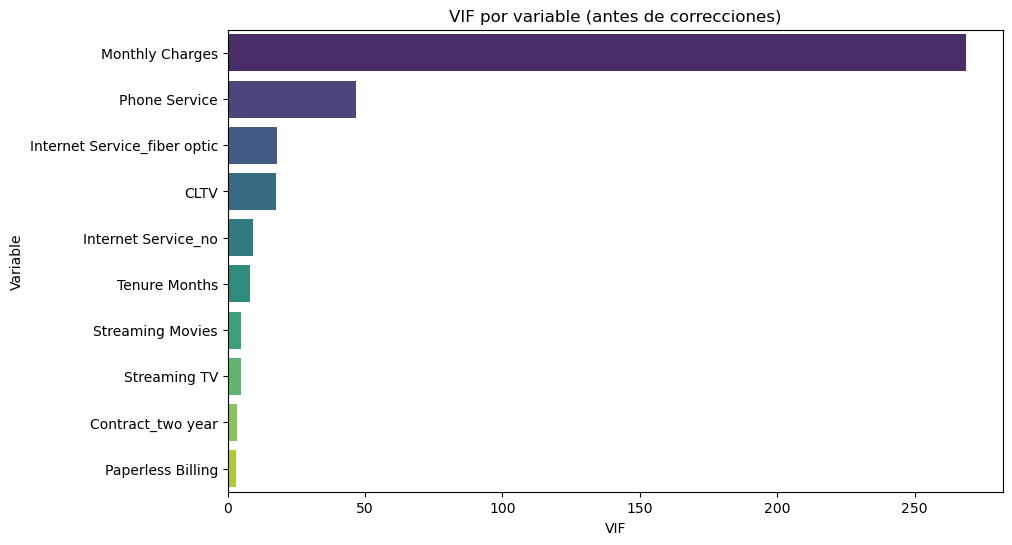

In [71]:
plt.figure(figsize=(10, 6))
sns.barplot(data=vif.sort_values("VIF", ascending=False), 
            x="VIF", y="feature", palette="viridis")
plt.title("VIF por variable (antes de correcciones)")
plt.xlabel("VIF")
plt.ylabel("Variable")
plt.show()


In [72]:
X_modified = X_train.drop(columns=["Monthly Charges","CLTV"])

In [73]:
vif_modified = calc_vif(X_modified)
vif_modified

,feature,VIF
5,Phone Service,9.205588
4,Tenure Months,7.425138
14,Internet Service_fiber optic,3.635393
17,Contract_two year,3.453019
15,Internet Service_no,3.391528
13,Paperless Billing,2.745544
12,Streaming Movies,2.737658
11,Streaming TV,2.730619
2,Partner,2.579132
6,Multiple Lines,2.442578


C:\Users\osian\AppData\Local\Temp\ipykernel_4484\3045609489.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_modified.sort_values("VIF", ascending=False),


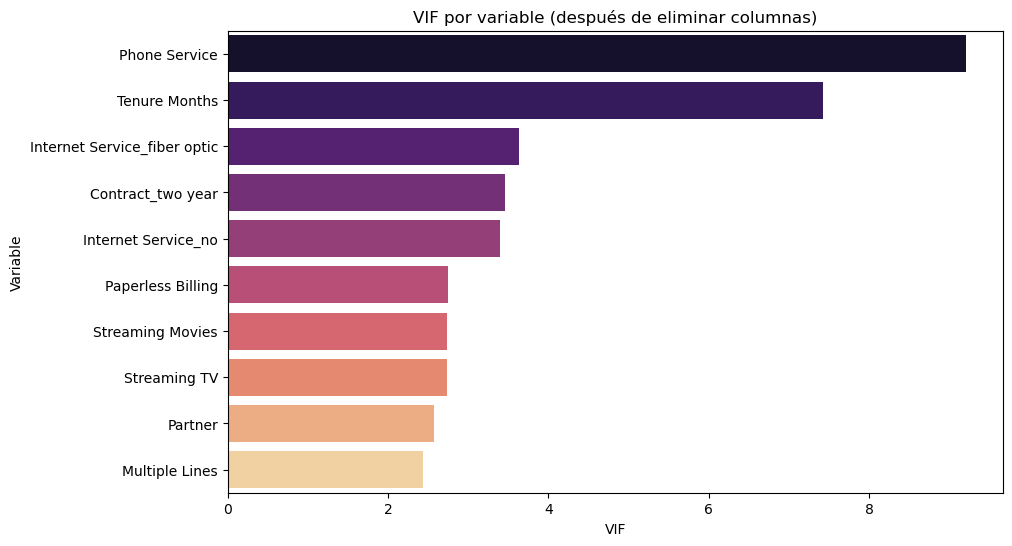

In [74]:
plt.figure(figsize=(10,6))
sns.barplot(data=vif_modified.sort_values("VIF", ascending=False), 
            x="VIF", y="feature", palette="magma")
plt.title("VIF por variable (después de eliminar columnas)")
plt.xlabel("VIF")
plt.ylabel("Variable")
plt.show()


### La variable Monthly Charges está claramente explicada por otras variables dentro del modelo. Tengo que tomar la decisión de si es más importante eliminar esta variable y perder un fuerza interpretativa o quedarme con el modelo menos dimensionado. Para ello voy a comprobar si realmente pierdo capacidad de predicción al mantener dicha columna


### Caminos a seguir: analisis a partir de AUC, Accuracy y Sensibilidad

In [75]:
X_train.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Paperless Billing', 'Monthly Charges', 'CLTV',
       'Internet Service_fiber optic', 'Internet Service_no',
       'Contract_one year', 'Contract_two year',
       'Payment Method_credit card (automatic)',
       'Payment Method_electronic check', 'Payment Method_mailed check'],
      dtype='object')

In [78]:
X_train_A = X_train.drop(columns=["Gender"])
X_test_A  = X_test.drop(columns=["Gender"])

X_train_B = X_train.drop(columns=["Monthly Charges"])
X_test_B  = X_test.drop(columns=["Monthly Charges"])

X_train_C = X_train.drop(columns=["Monthly Charges", "Tenure Months", "Phone Service"]) # aqui seguimos la pauta VIF < 5
X_test_C  = X_test.drop(columns=["Monthly Charges", "Tenure Months", "Phone Service"])

X_train_D = X_train.drop(columns=["Phone Service"])
X_test_D  = X_test.drop(columns=["Phone Service"])

X_train_E = X_train.drop(columns=["Internet Service_fiber optic", "Phone Service", "Monthly Charges"])
X_test_E  = X_test.drop(columns=["Internet Service_fiber optic", "Phone Service", "Monthly Charges"])

X_train_F = X_train
X_test_F  = X_test


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score

# Diccionario con los distintos conjuntos de features
datasets = {
    "A": (X_train_A, X_test_A),
    "B": (X_train_B, X_test_B),
    "C": (X_train_C, X_test_C),
    "D": (X_train_D, X_test_D),
    "E": (X_train_E, X_test_E),
    "F": (X_train_F, X_test_F),
}

resultados = {}
modelos = {}

for nombre, (X_train_i, X_test_i) in datasets.items():
    # entrenas regresión logística
    modelo = LogisticRegression(max_iter=1000)
    modelo.fit(X_train_i, y_train)

    # guardo el modelo por si lo quieres usar después
    modelos[nombre] = modelo

    # evalúas
    y_pred_i = modelo.predict(X_test_i)
    y_proba_i = modelo.predict_proba(X_test_i)[:, 1]

    acc_i = accuracy_score(y_test, y_pred_i)
    auc_i = roc_auc_score(y_test, y_proba_i)
    recall_i = recall_score(y_test, y_pred_i, pos_label=1)
    f1_i = f1_score(y_test, y_pred_i, pos_label=1)

    resultados[nombre] = {
        "accuracy": acc_i,
        "roc_auc": auc_i,
        "recall": recall_i,
        "f1": f1_i,
    }

# Pasar a DataFrame para verlo más cómodo
resultados_df = pd.DataFrame(resultados).T
print(resultados_df)


C:\tools\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\tools\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

   accuracy   roc_auc    recall        f1
A  0.809749  0.852369  0.584670  0.620038
B  0.810222  0.852307  0.584670  0.620624
C  0.783720  0.833322  0.552585  0.575673
D  0.805017  0.851135  0.566845  0.606870
E  0.803124  0.845477  0.581105  0.610487
F  0.809749  0.852386  0.584670  0.620038


C:\tools\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### La métrica relevante es el AUC y la SENSIBILIDAD, que en este caso son 0.85 y 0.58 respectivamente, lo que indica un modelo sólido y bien calibrado, aunque con un déficit de capacidad de predecir los clientes que se van
## nos quedamos con la opción F, ya que evidentemente mantener la columna Monthly Charges no afecta practicamente a la capacidad de predicción

##### el modelo identifica correctamente al 58 % de los clientes que abandonan el servicio, dejando sin detectar aproximadamente al 42 %. Por tanto, la capacidad de detección de clientes en riesgo de churn es limitada y presenta margen de mejora, especialmente si el objetivo de negocio es minimizar las bajas no anticipadas.” 
### Solucionaremos este problema en la siguiente fase del proyecto, aplicando smote a nuestros datos

In [76]:
with open("train_test_data.pkl", "wb") as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)
